# Chapter 7: Relationships Between Variables

Prior chapters explored *one* variable at a time. 

2 variables are related if knowing one *gives you info about the other*. 

For example, height & weight are related. People who are taller tend to be heavier. Of course, it's not a perfect relationship: there are short heavy people & tall light ones.

In [185]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline

## Scatter Plots
Simplest method of checking for a relationship between 2 variables. However, making a good scatter plot is not always easy.

In [186]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

In [187]:
from brfss import *

df = ReadBrfss()
sample = SampleRows(df, 5000) # random sub-set of data
heights, weights = sample.htm3, sample.wtkg2

Create a new `clean` DataFrame that has any rows with missing `height` or `weight` dropped.

In [188]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])
clean_hgt, clean_wgt = cleaned.htm3, cleaned.wtkg2

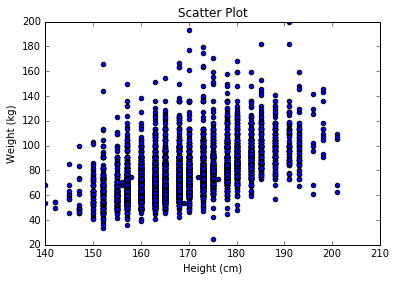

In [189]:
plt.scatter(heights, weights)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.xlim([140, 210])
plt.ylim([20, 200])
plt.title('Scatter Plot')
plt.show()

**Conclusion**: The figure shows the shape of the relationship. As expected, taller people tend to be heavier.

#### Drawback
This is not the best representation of the data because the *data are packed into columns*.  

**Problem**: `heights` are rounded to the nearest inch, converted to centimeters, and then rounded again. *Some info is lost in translation*.
  * `Heights` might be off up to 0.5 in or 1.3 cm.
  * `Weights` might be off by 0.5 kg.

#### Solution: `Jittering`
Can't get th information lost in translation back, but we can *minimize the effect* on the scatter plot by **jittering the data**.

**Jittering**: adding random noise to reverse the effect of rounding off.
  * Reduces the visual effect of rounding & makes the shape of the relationship clearer.
  * Should only jitter data for **purposes of data visualization**, *avoid using jittered data for analysis*.

In [190]:
def Jitter(values, jitter=0.5):
    """Jitters the values by adding a uniform variate in (-jitter, jitter).

    values: sequence
    jitter: scalar magnitude of jitter
    
    returns: new numpy array
    """
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values

In [191]:
jitter_hgt = Jitter(heights, 1.3)
jitter_wgt = Jitter(weights, 0.5)

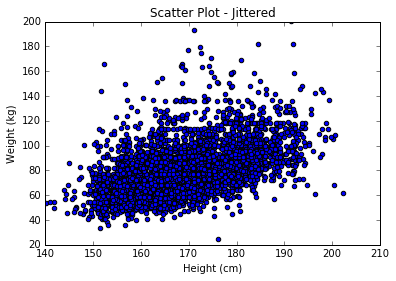

In [192]:
plt.scatter(jitter_hgt, jitter_wgt)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.xlim([140, 210])
plt.ylim([20, 200])
plt.title('Scatter Plot - Jittered')
plt.show()

##### Drawbacks of Jittering
  1. **Saturation**: loss of info when multiple points are plotted *on top of each other*.
    * many overlapping points that hides data in the dense parts of the figure & gives **disproportionate emphasis to outliers**.
  
##### **Solution**: Transparency (`alpha` parameter)
`alpha` parameter makes the points partly tranparent. Darkness of points is proportional to density.
  * *Overlapping points* look darker
  
Transparency works well for *moderate-sized* datasets.

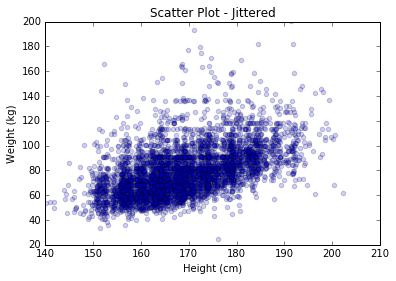

In [193]:
plt.scatter(jitter_hgt, jitter_wgt, alpha=0.2)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.xlim([140, 210])
plt.ylim([20, 200])
plt.title('Scatter Plot - Jittered')
plt.show()

**New Conclusions**: The `alpha` parameter reveals 2 details not apparent before due to the lack of proportionality with respects to density of data points.
  * Vertical clusters at several heights
  * Horizontal line near 90 kg or 200 lbs

### Hexbin Plot
As previously mentioned, **transparency** only works well for *moderate-sized datasets*. For larger datasets, hexbin plots are more appropriate.

**Hexbin Plots**: divides the graph in to hexagonal bins & clors each bin according to how many data points fall in it.

**Advantages**
  * shows the shape of the relationship well
  * it's efficient for large datasets (both time & size of file generated)
  
**Disadvantages**
  * outliers are made invisible

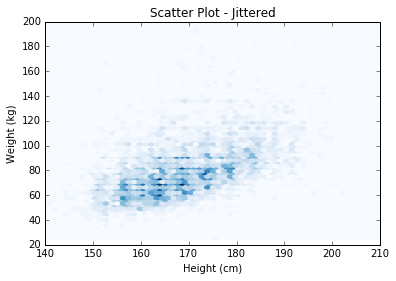

In [194]:
import matplotlib
plt.hexbin(jitter_hgt, jitter_wgt, cmap=matplotlib.cm.Blues)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.xlim([140, 210])
plt.ylim([20, 200])
plt.title('Scatter Plot - Jittered')
plt.show()

## Characterizing Relationships
**Scatter plots** provides a *general impression* of the relationship between variables. There are other visualizations that provide more insight into the nature of the relationship.

### Alternative Visualization: Bin var `x` & Plot var `y`
**Bin** 1 variables & plot of **Percentiles** of the other.

`NumPy` & `pandas` provide functions for binning data
  1. Drop nan values of listed columns [`pd.dropna()`]
  2. Create NumPy array of **bins** [`np.arange(start, exclusive_end, increment)`]
  3. np.**digitize()** computes the index of the bin that contains each value. Values below the lowest bin are mapped to `index 0` & values above the highest bin are mapped to `len(bins)`.
  4. pd.**groupby()** returns a GroupBy object used in `for loops`. Groups iterates the names of the groups & the DataFrames that represent them
  
##### Example: Number of Rows in each Group
Print the number of rows in each group  
`for i, group in groups:
    print (i, len(group))`

In [195]:
df = df.dropna(subset=['htm3', 'wtkg2']) # drop nan of listed cols
bins = np.arange(135, 210, 5) # bins
indices = np.digitize(df.htm3, bins) # indices
groups = df.groupby(indices) # groups

In [196]:
for i, group in groups:
    print (i, len(group))

(0, 305)
(1, 228)
(2, 477)
(3, 2162)
(4, 18759)
(5, 45761)
(6, 70610)
(7, 72138)
(8, 61725)
(9, 49938)
(10, 43555)
(11, 20077)
(12, 7784)
(13, 1777)
(14, 405)
(15, 131)


Compute the mean `height` & CDF of `weight` in each group. 

https://philbull.wordpress.com/2012/01/11/numpy-tip-getting-index-of-an-array-element-nearest-to-some-value/

In [197]:
def find_nearest(seq, value):
    idx = (np.abs(np.array(seq)-value)).argmin()
    return idx


def cdf_percentile(perc):
    """Returns the value that corresponds to percentile.

    Args:
        perc: number in the range [0, 100]

    Returns:
        number value
    """
    wgt = []
    for prob in p:
        wgt += [perc / 100.0]
    return wgt

In [198]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [ECDF(group.wtkg2) for i, group in groups]

Extract the 25th, 50th, & 7th percentile from each group. Then, plot the percentiles of `weight` versus `height`.

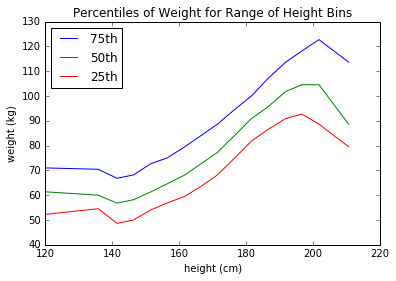

In [199]:
for percent in [75, 50, 25]:
    wgt_percentiles = []
    for ecdf in cdfs:
        idx = find_nearest(ecdf.y, percent/100.0)
        wgt_percentiles += [ecdf.x[idx]]
    p_label = '%dth' % (percent)
    plt.plot(mean_heights, wgt_percentiles, label=p_label)
    plt.xlabel('height (cm)')
    plt.ylabel('weight (kg)')
    plt.title('Percentiles of Weight for Range of Height Bins')
    plt.legend(loc='upper left')
plt.show()

**Conclusions**
  * Between 140 & 200 cm, the relationship between these variables is *roughly linear*. This range includes > 99% of the data, so we don't havec to worry too much about the extremes.


## Correlation

**Correlation**: a statistic intended to quantify the *strength of the relationship* between 2 variables.

#### Challenges 
A common challenge in measuring correlation is:
  * Variables we want to compare are often not expressed in the **same units**.
  * If they are in the *same units*, they come from **different distrbutions**.


#### Solutions
2 common solutions address these problems is to *transform each value to a*:
  1. **Standard Scores** (**Pearson product-moment correlation coefficient**): a value that has been standardized so that it's expressed in *standard deviations from the mean*.
     * number of standard deviations from the mean
     * **Standardize**: transform a set of values so that their `mean` is 0 and `variance` is 1.

  2. **Rank** (**Spearman Rank Correlation Coefficient**): index in the sorted list of values
    
If `X` is a series of `n` values, *x*<sub>i</sub>, we can convert to **standard scores** by substracting the `mean` & dividing by the `standard deviation`:  
***z*<sub>i</sub> = (*x*<sub>i</sub> - μ) / σ**

  * The numerator is a **deviation**: the distance from the mean. Dividing by σ **standardizes** the deviation, so  the values of `Z` are dimensionless (*no units) & their distribution has `mean` = 0 and `variance` = 1.
    
If `X` is normally distributed, so is `Z`. But if `X` is *skewed* or *has outliers*, so does `Z`. In those cases, it's more robust to use **percentile ranks**. If we compute a new variable, `R` (so that *r*<sub>i</sub> is the rank of *x*<sub>i</sub>) the distribution of `R` is uniform from 1 to `n`, regardless of the distribution of `X`.

## Covariance
**Covariance**: a measure of the tendency of 2 variables to vary together.  

If we have 2 series, `X` & `Y`, their deviations from the mean are:  
**d*x*<sub>i</sub> = *x*<sub>i</sub> - x<sub>mean</sub>**  
**d*y*<sub>i</sub> = *y*<sub>i</sub> - y<sub>mean</sub>**

where x<sub>mean</sub> = the sample mean of `X` & y<sub>mean</sub> = the sample mean of `Y`.  

If `X` & `Y` *vary together*, their deviations tend to have the *same sign*.

If we multiply them together, the product is *positive* when the deviations have the *same sign* & *negative* when they have the *opposite sign*. Thus, adding up the products gives a **measure of the tendency to vary together**.

**Covariance** is the *mean of these products*:  
`Cov(X,Y)`= `(1/n) * Σ dx`<sub>i</sub>`dy`<sub>i</sub>  
where `n` = the length of the 2 series (must be same length).
  * `Cov` is the *dot product* of the deviations, divided by their length.
  * Covariance is 
    * maximized if the 2 vectors are identical
    * 0 if they're orthogonal
    * negative if they point in opposite directions
    
### `Cov` Function
By default:
  * `Cov` computes deviations from the sample means, or you can provide known means.
  * If `xs` & `ys` are Python sequences, `np.asarrays` converts them to NumPy arrays. If they are already NumPy arrays, `np.asarrays` does nothing.
  
This implementation of **covariance** is meant to be simple for purposes of explanation. `NumPy` & `pandas` also provide implementations of covariance, but both *apply a correction for small sample sizes*.
  * `np.cov` returns a **covariance matrix**

In [200]:
def Cov(xs, ys, meanx=None, meany=None):
    """Computes Cov(X, Y).

    Args:
        xs: sequence of values
        ys: sequence of values
        meanx: optional float mean of xs
        meany: optional float mean of ys

    Returns:
        Cov(X, Y)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)
    
    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

### Example: Covariance of Adult `Height` & `Weight`

In [201]:
Cov(clean_hgt, clean_wgt)

103.33290857697767

**Conclusions**
  * The covariance of adult `height` & `weight` has a value of 103.33 kilogram-cm.

### Shortcomings of Covariance
Covariance is useful in some computations, but is *seldom reported as a summary statistic* because it's hard to interpret. 

Another problem is that its units are the product of the units of `X` & `Y`. For example, the **covariance** of `weight` & `height` in the BRFSS dataset is **8113 kg-cm**...whatever that means.

##### Solutions
The **coefficient** of correlations are a *standardized version* of covariance that's easier to interpret. 
  1. **Pearson's Correlation**
  2. **Spearman's Rank Correlation**

## Pearson's Correlation

A solution to issues inherent with **covariance** by 
  1. dividing the deviations by the standard deviations, yielding **standard scores**. 
  2. Then, computing the *product* of standard scores: ***p*<sub>i</sub> = ( (*x*<sub>i</sub> - x<sub>mean</sub>)/ S<sub>X</sub>) * (*y*<sub>i</sub> - y<sub>mean</sub>)/ S<sub>Y</sub>)**  
    where S<sub>X</sub> & S<sub>Y</sub> are the *standard deviations* of `X` & `Y`.

The **mean** of these products is:  
** *p*= (1/`n`) * Σ *p*<sub>i</sub>**  
which is equivalent (==) to:  
** *p* = `Cov(X, Y)` / S<sub>X</sub> * S<sub>Y</sub>**
  
Easy to interpret: **standard scores** are dimensionless, so is ** *p* **.

#### Pearson's Correlation Value (`p`)
  * **[-1, +1]** -- Pearson's Correlation is always between `-1` & `+1`, inclusive of both.
    * If `p` is **positive** (** *p* > 0**), the *correlation is positive*.  This means when 1 variable is high, the other tends to be high.
    * If `p` is **negative** (** *p* < 0**), the *correlation is negative*. Thus, when 1 variable is high, the other tends ot be low.
  * **Magnitude** of `p` indicates the strength of the correlaiton.
    * If `p` is **1** or **-1**, the variables are *perfectly correlated*. Thus, meaning if you know 1 variable, you can make a perfect prediction about the other.  
    
   
Most *correlation* in the real world is not perfect, but still useful. The correlation of `height` & `weight` is 0.51, which is a *strong correlation* compared to similar human-related variables.
#### Shortcomings
Only measure's **linear relationships**. `p` understates its strength for *nonlinear* relationships.


### `Corr` Function
`MeanVar` computes **mean** & **variance** sligtly more efficiently than separate calls to `np.mean` & `np.var`.


In [202]:
def Var(xs, mu=None, ddof=0):
    """Computes variance.

    xs: sequence of values
    mu: option known mean
    ddof: delta degrees of freedom

    returns: float
    """
    xs = np.asarray(xs)

    if mu is None:
        mu = xs.mean()

    ds = xs - mu
    return np.dot(ds, ds) / (len(xs) - ddof)

def MeanVar(xs, ddof=0):
    """Computes mean and variance.

    Based on http://stackoverflow.com/questions/19391149/
    numpy-mean-and-variance-from-single-function

    xs: sequence of values
    ddof: delta degrees of freedom
    
    returns: pair of float, mean and var
    """
    xs = np.asarray(xs)
    mean = xs.mean()
    s2 = Var(xs, mean, ddof)
    return mean, s2

In [203]:
def Corr(xs, ys):
    """Computes Corr(X, Y).

    Args:
        xs: sequence of values
        ys: sequence of values

    Returns:
        Corr(X, Y)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = MeanVar(xs)
    meany, vary = MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / math.sqrt(varx * vary)

    return corr

### Example: Correlation of Adult `Height` & `Weight`

In [204]:
Corr(clean_hgt, clean_wgt)

0.50873647897346075

**Conclusion**
  * The correlation of `height` & `weight` is about 0.51, which is a moderately strong correlation.

#### Alternative Method: NumPy's `np.corrcoef`
NumPy provides a function to compute correlations too.

The result is a matrix with **self-correlations** on the diagonal (*which are always **1** *), and **cross-correlations** on the off-diagonals (*which are always **symmetric***).

In [205]:
np.corrcoef(clean_hgt, clean_wgt)

array([[ 1.        ,  0.50873648],
       [ 0.50873648,  1.        ]])

## Non-Linear Relationships

If **Pearson's Correlation** is near `0`, it's tempting to conclude that there's no relationship between the variables. ** *But that conclusion is NOT valid* **. **Pearson's correlation** only measures *linear* relationships.

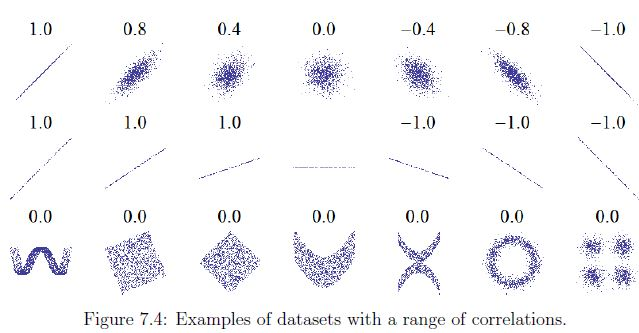

In [206]:
from IPython.display import Image, display
import platform

if platform.system()=='Linux':
    display(Image(filename='C:\Users\Calvin\Desktop\HS 699\code\correlation.jpg'))
if platform.system()=='Windows':
    display(Image(filename='C:\Users\Calvin\Desktop\HS 699\code\correlation.jpg'))

### Figure 7.4: Range of Correlations
http://wikipedia.org/wiki/Correlation_and_dependence
The figure shows *scatter plots* & *correlation coefficients* for several constructed datasets.

##### Top Row
The top row shows ** *linear* relationships** with a range of correlations. You can use this row to get a sense fo what different values of `p` look like.

##### 2nd Row
The 2nd row shows ** *perfect* correlations** with a range of slopes. This demonstrates that *correlation is unrelated to slope*.

##### 3rd Row
3rd row shows variables that are clearly related, but because the relationship is **nonlinear**, *the correlation coefficient (`p`) is 0*.


#### Moral of the Story
Always look at the **scatter plot**, *before blindly computing a **correlation coefficient** *.

## Spearman's Rank Correlation
**Pearson's Correlation** works well if the 
  * relationship between variable is *linear* 
  * if the variables are *roughly normal*.
  
It is not robust in the *presence of **outliers** *.

**Spearman's rank correlation** is an alternative solution that mitigates the *effects of outliers* & *skewed distributions*.

To compute the **Spearman's correlation**, we have to compute the **rank** of each value, which is its index in the sorted sample.
  * **Rank**: the index where an element appears in a sorted list.

**Example**: Sample [1, 2, 5, 7]   
To compute the Spearman's correlation, compute the ranks first. In the sample, the **rank** of the value 5 is 3 because it appears 3rd in the sorted list. Then, compute the **Pearson's correlation** for the ranks.

### `SpearmanCorr` Function
#### Method 1: Manual
Manually calculate the **ranks** of each value and subsequently, the **Pearson's correlation** of the ranks.

Steps:
  1. Convert the sequence arguments to pandas `Series` objects.
  2. Apply the `Series.rank()` method - computes the **rank** for each value & returns a Series.
  3. Use `Corr` function to compute the correlation of the ranks.

In [207]:
def SpearmanCorr(xs, ys):
    """Computes Spearman's rank correlation.

    Args:
        xs: sequence of values
        ys: sequence of values

    Returns:
        float Spearman's correlation
    """
    # Calculate the ranks of each value
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    # Calculate the Pearson's correlation for the ranks
    return Corr(xranks, yranks)

#### Method 2: `Series.corr` (pandas' method)
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html

`method` parameter specifies the type of correlation to calculate.

In [208]:
def SpearmanCorr_1(xs, ys):
    xs = pandas.Series(xs)
    ys = pandas.Series(ys)
    return xs.corr(ys, method='spearman')

In [209]:
from brfss import *

df = ReadBrfss()
# sample = SampleRows(df, 5000) # random sub-set of data
heights2, weights2 = df.htm3, df.wtkg2

### Example: Correlation of Adult `Height` & `Weight`
Both methods of calculating **Spearman's rank correlation** is equivalent (*manual* or *pandas' method*). 

In [210]:
SpearmanCorr(clean_hgt, clean_wgt) # manual method

0.54058462623204762

In [211]:
SpearmanCorr_1(clean_hgt, clean_wgt) # pandas method

0.54058462623204906

**Conclusions**
The result of **Spearman's correlation** (0.54) is a little higher than that of **Pearson's correlation** (0.51). Several possible reaons for the difference include:
  * If the relationship is *nonlinear*, **Pearson's correlation** tends to *underestimate* the stregnth of the relationship.
  * **Pearson's correlation** can be affected (in either direction) if 1 of the distributions is *skewed* or contains *outliers*. **Spearman's rank correlation** is more robust.

#### Distribution Skewness
In the BRFSS example, we know that the **distribution of the `weights` is roughly *lognormal* **. Under a `log` transform, it approximates a *normal distribution*. Thus, *having no skew*

Therefore to eliminate the effect of *skewness* is to compute **Pearson's correlation** with `log-weight` & `height`. 

In other words, an alternative to Spearman's correlation is to transform 1 or more of the variables in a way that makes the relationship closer to *linear* and then compute the Pearson's correlation.

In [212]:
Corr(clean_hgt, np.log(clean_wgt))

0.53172826059834433

**Conclusion**:  
The result is a **Pearson's correlation** value of 0.53, which is more close to the **rank correlation** (0.54). Thus, suggesting that *skewness in distribution* of `weight` explains most of the difference between **Pearson's** & **Spearman's correlation**.

## Correlation & Causation
If variables `A` & `B` are correlated, there are 3 possible explanations:
  * `A` causes `B`
  * `B` causes `A`
  * some other set of factors causes *both* `A` & `B`
  
 These explanations are called "**causal relationships**".
 
 ### *"Correlation does not imply causation."*
 This rule states that **correlation** alone does NOT distinguish between these explanations. Thus, it does not tell you which ones are true.
 
### Providing Evidence of Causation
So what can you do to provide evidence of causation?
  1. **Use Time**
    * If `A` comes before `B`, then `A` can cause `B` but not the other way around. 
    * The order of events can help us infer the direction of causation, but does not preclude the possibility that *something else* causes both `A` & `B`.
  2. **Use Randomness**
    * If you divide a large sample into 2 groups at random & compute the means of almost any variable, you expect the difference to be small.
    * If the groups are nearly identical inall variables but one, you  can eliminate spurious relationships. This works even if you don't know what the relevant variables are, but wrks even better if you do (you can check that the groups are identical).

#### Randomized Controled Trial
These ideas are the motivation for **randomized controlled trial**.
  * an experimental design in which usbjects are divided into groups at random. Different groups receive different treatments.
  * Subjects are assigned randomly to 2 (or more) groups: 
    * **treatment group**: received some kind of intervention
    * **control group**: received no intervention (or another treatment whose effects are known).
  * A randomized controlled trial is the most reliable way to demonstrate a **causal relationship**.
  
Unfortunately, controlled trials are only possible in the laboratory sciences, medicine, and a few other disciplines. It's rare to have controlled experiments in the social sciences due to impossibility or unethical principles.

An alternative is to look for a **natural experiment**, where different 'treatments" are applied to groups that are otherwise similar. One danger of such experiments is that groups might differ in ways that are not apparent.

In some cases, it's possible to *infer causal relationships* using **regression analysis**.
    